In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm

In [45]:
dt = 0.2
D = 1.0
L = 11.0
xl = 5.0
xr = 6.0
N = 5
length = 1000000

In [46]:
# generate steps for all particles
steps=np.random.normal(loc=0.0, scale=2*D*dt, size=(N,length))

In [47]:
# initial positions
x = L*np.random.random(size=(N,))

In [48]:
# put initial position in front
x = np.column_stack((x, steps))

In [49]:
# calculate paths
paths = np.mod(np.cumsum(x, axis=1),L)

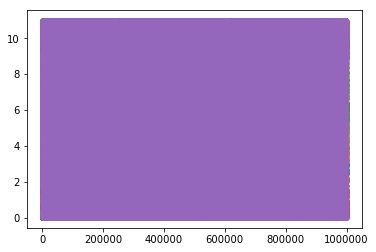

In [50]:
for path in paths:
    plt.plot(path,".")

In [51]:
# place a Gaussian illumination at x=5.5 with unit variance
from scipy.stats import norm
intensity = norm.pdf(paths, loc=5.5)
#print(intensity)
intensity = np.sum(intensity, axis=0)
#print(intensity)

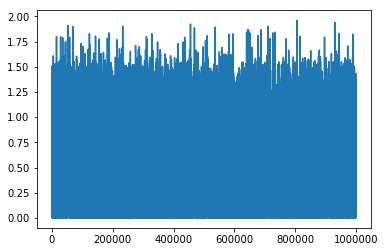

In [52]:
plt.plot(intensity)

0.424221708199


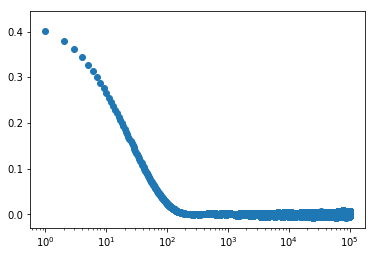

In [53]:
# calculate autocorrelation function
f = np.fft.rfft(intensity)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / length
autocorr = acf[int(length/2):]/intensity.mean()**2

autocorr = autocorr[:100000]-1.0
t = np.arange(0,autocorr.size)
plt.semilogx(t,autocorr,"o")
print(autocorr[0])

In [54]:
def corrfit(s,N,D,gamma,w0):
    return 1/N/(1+4*D*dt*s/w0**2)**gamma

In [55]:
corrfit_model=lm.Model(corrfit)
params = corrfit_model.make_params()
params['w0'].set(value=2,vary=False)
params['N'].set(value=2,vary=True)
params['D'].set(value=1,vary=True)
params['gamma'].set(value=0.5,vary=False)

result = corrfit_model.fit(s=t,data=autocorr,params=params)

In [56]:
print(result.fit_report())

[[Model]]
    Model(corrfit)
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 100000
    # variables        = 2
    chi-square         = 1.784
    reduced chi-square = 0.000
    Akaike info crit   = -1093422.613
    Bayesian info crit = -1093403.587
[[Variables]]
    N:       2.08949693 +/- 0.018301 (0.88%) (init= 2)
    D:       16.9415943 +/- 0.346954 (2.05%) (init= 1)
    gamma:   0.5 (fixed)
    w0:      2 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(N, D)                      = -0.879 



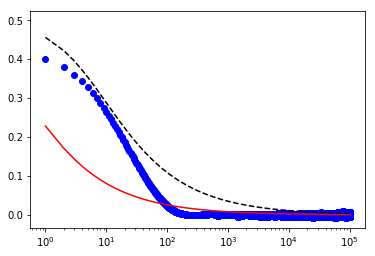

In [57]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, result.init_fit, 'k--')
plt.semilogx(t, result.best_fit, 'r-')